# Solution: Writing a sum-of-squares function in R, for SIR model fitting


For each observed datapoint, with the appropriate matching time point in model output, you need to:
* calculate their $\delta$ (difference between the two)
* square each $\delta$
* sum all the squared deltas together
* save and return that value.

Your model outputs should be at a dense series of timepoints, e.g. every 0.1 days, but your observed data will probably only be available for a small subset, e.g. once every day. There may also be observations missing - NAs in your dataset.
So you will need to account for this by selecting the appropriate data. You may find the function ```%in%``` useful. Within your SSQ function, you could use ```na.omit()``` on the data (rather than altering the dataframe itself outside of the function).

Finally, think about sensible variable and column names. Real-world data may come with a variety of names, and it will need to be clear in your functions which data or columns to use. It may be necessary to change column names in the incoming data to ensure it can be properly processed. (There are other ways of achieving a working, widely applicable function, like writing the function to specify the correct column name when you run the function, as one of the arguments.)

Let's go over how to do this in detail.

Contents:  
[1. Load and check data](#data)  
[2. Define model function](#model)  
[3. Run a quick test](#test)  
[4. Sum-of-squares calculation](#SSQ)  
[5. Further work: take in any function to ode()](#any_func)  

## 1. Load and check data <a name="data"></a>

Let's bring in the observed epidemiological data we'll need.

In [1]:
# Load observed data
flu_data <- read.csv("../GraphicsAndData/idm2_sir_data.csv") # on Coursera only

# Set up initial state for the model
initial_state_values <- c(S = 762, I = 1, R = 0)

# Our function requires data in a column named 'I'
# Let's check whether it does by printing their names...
colnames(flu_data)

[1] "time"            "number_infected"

Seems the data provided does not have a column titled 'I'. That's quite common as naming conventions aren't always consistent. In this case the data we're looking for is in 'number_infected'.

So we'll have to rename the column to match what our SIR_SSQ function is expecting:

In [2]:
# It's the second column we want to change. We can use the colnames() function
# to rename as well; we select the second column and assign it the new value.
# Note column names are characters (or strings of characters),
# so they must be in quote marks.

colnames(flu_data)[2] <- "I"

# Check the new name
colnames(flu_data)

[1] "time" "I"

## 2. Define model function <a name="model"></a>
We'll need the SIR model function we wrote previously.

In [3]:
# Load packages
require(deSolve)

# Define the Susceptible-Infected-Recovered model
SIR_model <- function(time, state, parameters) {
   
    with(as.list(c(state, parameters)), {
        N  <- S+I+R
   
        dS <- -beta*S*I/N
        dI <- beta*S*I/N-gamma*I
        dR <- gamma*I
     
        return(list(c(dS, dI, dR)))
    
    })
    
}

Loading required package: deSolve


## 3. Running a test <a name="test"></a>
Let's run a quick test of the model.

Loading required package: ggplot2


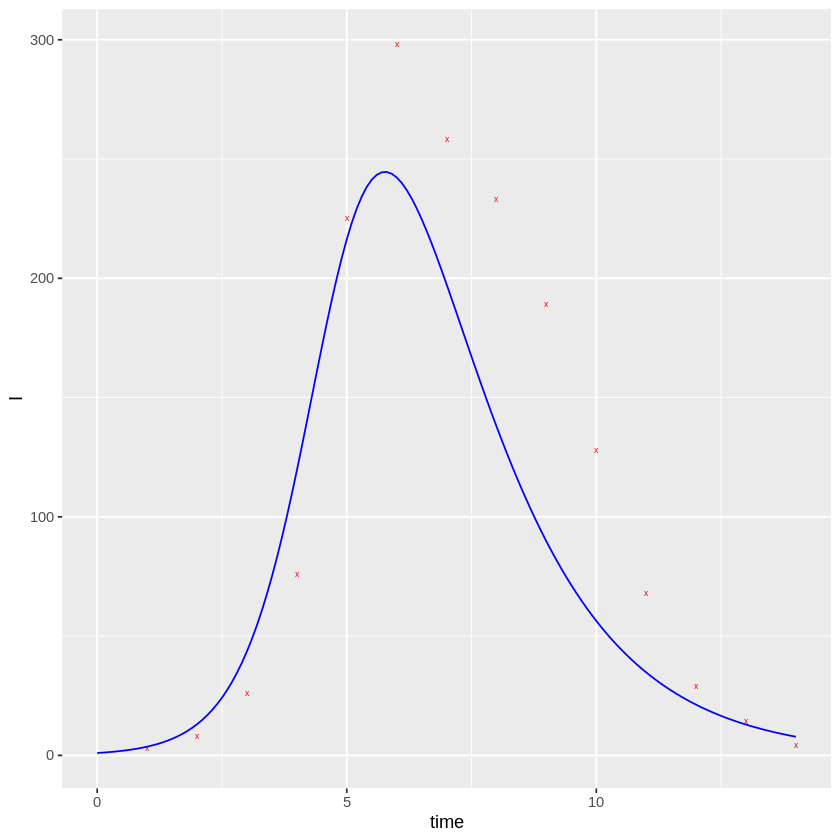

In [4]:
require(deSolve)

# Make the timesteps small for more detailed output
times <- seq(from = 0, to = 14, by = 0.1) 

# Try a parameter set - we'll just pick this arbitrarily for demonstration purposes.
parameters <- c(beta = 1.9, gamma = 0.6)

# Run the model
result <- as.data.frame(ode(y = initial_state_values, # vector of initial state values
                                                      # with named elements
                            times = times,            # vector of times
                            func = SIR_model,         # your predefined SIR model function
                            parms = parameters)       # the parameters which
                                                      # SIR_model needs
)

# Plot your data against model output to check it
require(ggplot2)
res_plot <- ggplot() # initialise, but don't assign data

res_plot <- res_plot + geom_point(aes(x = time, y = I)
                                , colour = "red"
                                , shape  = "x" 
                                , data = flu_data)
res_plot <- res_plot +  geom_line(aes(x = time, y = I)
                                , colour = "blue"
                                , data = result)

res_plot

## 4. Sum-of-squares function <a name="SSQ"></a>

At its core, the SSQ calculation should have the following structure. You can test this using the output from the previous cell:

In [5]:
# Ensure we're working with equivalent time points
matched_results <- result$I[result$time %in% flu_data$time] # selects elements where results$time is in flu_data$time

# Calculate squared differences between model output and observed data
deltas2 <- (matched_results - flu_data$I)^2

# Then calculate their sum
SSQ   <- sum(deltas2)

# And take a look
SSQ

[1] 34243.68

And now the whole function:

In [6]:
# Define a function to calculate the sum of squared differences 
# between the SIR model output and observed epidemiological data.
# Arguments:
#    'parameters': must contain beta and gamma model parameters.
#    'reported_data': will be the data to compare with. The relevant data must be in a column named 'I'.
SIR_SSQ <- function(parameters, reported_data) {
    
    # Calculate model output using our SIR function and the provided parameters
    result <- as.data.frame(ode(  y = initial_state_values  # named vector of initial state values
                            , times = times                 # vector of times
                            ,  func = SIR_model             # predefined SIR function
                            , parms = parameters)           # the parameters argument
    )

    # Do some pre-processing of observed data:
    # select only complete cases (i.e. rows with no missing data)
    reported_data <- na.omit(reported_data)
    
    # Ensure we're working with equivalent time points by 
    # selecting elements where results$time is in reported_data$time
    matched_results <- result$I[result$time %in% reported_data$time]
    
    # Calculate squared differences between model output and observed data
    deltas2 <- (matched_results - reported_data$I)^2
    
    # Then calculate their sum
    SSQ   <- sum(deltas2)
    
    return(SSQ)
    
}

### Run full SSQ calculation

Now let's run the sum-of-squares function using the observed data and our two parameter sets:
 * $\beta$ = 1.15, $\gamma$ = 0.02
 * $\beta$ = 1.7,  $\gamma$ = 0.45


We should get an SSQ value for each set.

In [7]:
# There's more than one way to use our function.
# We can either create a variable to hold our parameters, and pass that to our functions...
parms <- c(beta = 1.15, gamma = 0.02)
ssq1 <- SIR_SSQ(parameters = parms, reported_data = flu_data)
print(paste0("ssq = ", ssq1, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))

# ... or pass the parameters directly
ssq2 <- SIR_SSQ(parameters = c(beta = 1.7, gamma = 0.45), reported_data = flu_data)
print(paste0("ssq = ", ssq2, ", where beta = 1.7, gamma = 0.45"))

# Remember that functions can often take in a vector or vectors by default.

[1] "ssq = 2507764.33057048, where beta = 1.15, gamma = 0.02"
[1] "ssq = 4630.302259291, where beta = 1.7, gamma = 0.45"


## 5. Further work - generalise SSQ function <a name="any_func"></a>

In the etivity we suggested a further task. How would you generalise your SSQ function to allow us to use it with any desired model function?

In [8]:
# Define a function to calculate the sum of squared differences 
# between any model's output and observed epidemiological data.
# Arguments:
#    'parameters': must contain beta and gamma model parameters.
#    'reported_data': will be the data to compare with. The relevant data must be in a column named 'I'.
#    'func': new - we'll use this to pass the name of a model function

SSQ <- function(func, parameters, reported_data) {  

    # Calculate model output - now using the model function named in the arguments
    result <- as.data.frame(ode(  y = initial_state_values      
                            , times = times                     
                            ,  func = func            # predefined function, as per the func argument
                            , parms = parameters)     # parameters for func
                            )
    
    # Do some pre-processing of observed data:
    # select only complete cases (i.e. rows with no missing data)
    reported_data <- na.omit(reported_data)
    
    # Ensure we're working with equivalent time points by 
    # selecting elements where results$time is in reported_data$time
    matched_results <- result$I[result$time %in% reported_data$time]
    
    # Calculate squared differences between model output and observed data
    deltas2 <- (matched_results - reported_data$I)^2
    
    # Then calculate their sum
    SSQ   <- sum(deltas2)
    
    return(SSQ)
    
}